# Контекст

- Задача суждения о приемлимости (предполагает, что участников просят оценить приемлемость предложений, что помогает исследователям понять, как говорящие воспринимают и обрабатывают лингвистические конструкции)
- модель: 'bert-base-uncased'
- метрика accuracy

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
from torch.utils.data import TensorDataset,\
                             DataLoader

# from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,\
                         BertConfig,\
                         BertModel
from transformers import AdamW,\
                         BertForSequenceClassification,\
                         get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Чтение данных

In [2]:
data = pd.read_csv('in_domain_train.tsv', delimiter = '\t', header = None, names = ['sentence_source', 'label', 'label_notes', 'sentence'])
data.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


# Добавление CLS и SEP токенов

In [3]:
sentences = data.sentence.values
labels = data.label.values
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

sentences[:2]

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]",
 "[CLS] one more pseudo generalization and i 'm giving up . [SEP]"]

# Загрузка токенизатора и его применение

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
tokenized_text = [tokenizer.tokenize(sentence) for sentence in sentences]
tokenized_text[0]

['[CLS]',
 'our',
 'friends',
 'wo',
 'n',
 "'",
 't',
 'buy',
 'this',
 'analysis',
 ',',
 'let',
 'alone',
 'the',
 'next',
 'one',
 'we',
 'propose',
 '.',
 '[SEP]']

In [5]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]
input_ids[0]

[101,
 2256,
 2814,
 24185,
 1050,
 1005,
 1056,
 4965,
 2023,
 4106,
 1010,
 2292,
 2894,
 1996,
 2279,
 2028,
 2057,
 16599,
 1012,
 102]

# Функция паддинга

In [6]:
def padding(
        sequence,
        max_lenght = 512
):
    padded_sequence = np.zeros(max_lenght, dtype = np.int64)
    for index, token_value in enumerate(sequence):
        padded_sequence[index] = token_value
    
    return padded_sequence


input_ids = [torch.LongTensor(padding(x, 128)) for x in input_ids]
input_ids[0]

tensor([  101,  2256,  2814, 24185,  1050,  1005,  1056,  4965,  2023,  4106,
         1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

# Функция attention mask

In [7]:
def attention_mask(
        sequence
):
    return [float(i>0) for i in sequence]

np.array(attention_mask(input_ids[0]))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
data = {
    'sequence': input_ids,
    'labels': data['label'],
    'attention_mask': [attention_mask(i) for i in input_ids],

}

data.keys()

dict_keys(['sequence', 'labels', 'attention_mask'])

# train val split 

In [9]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    data['sequence'], data['labels'],
    test_size = 0.1,
    random_state = 42
)


train_attention_mask, val_attention_mask, _, _ = train_test_split(
    data['attention_mask'], data['sequence'],
    test_size = 0.1,
    random_state = 42 
)

In [10]:
train_inputs = torch.vstack(train_inputs)
val_inputs = torch.vstack(val_inputs)

train_labels = torch.tensor(train_labels.values)
val_labels = torch.tensor(val_labels.values)

train_attention_mask = torch.tensor(train_attention_mask)
val_attention_mask = torch.tensor(val_attention_mask)

# Dataset, Dataloader

In [11]:
train_dataset = TensorDataset(train_inputs, train_attention_mask, train_labels)
# train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset,
    # sampler = train_sampler,
    batch_size = 32)



val_dataset = TensorDataset(val_inputs, val_attention_mask, val_labels)
# val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(
    val_dataset,
    # sampler = val_sampler,
    batch_size = 32)

# BertModel - BertConfig

In [12]:
config = BertConfig()
model = BertModel(config)
print(model.config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [13]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Подготовка параметров модели

In [14]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']


optimizer_grouped_parameters = [
 # Фильтр по всем параметрам, которые *не* включают 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

# Training loop

In [23]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg



def create_folder(name):
    import os
    os.mkdir(name)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [24]:
def training_loop(
        # папка сохранения
        name_model_folder,

        # основные настройки
        epoches,
        model,
        optimizer,
        metric_str,

        # контроль скорости
        scheduler_append,
        scheduler,
        step_on, # str 'val_loss', 'train_loss'

        # loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer_append,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        min_delta,
        patience,

        # verbose
        verbose_epoch
        ):
    
    
    create_folder(name_model_folder)
    
    loss_history = {
           'train_loss': [],
           'val_loss': []
    }

    metric_history = {
           'train_metric': [],
           'val_metric': []
    }

    best_loss = float('inf')
    patience_beginner = patience
    model = model.to(device)

    for epoch in range(1, epoches+1):
            
            start_time = time.time()
            model.train()
            current_lr = get_lr(optimizer)
            loss_train = 0.0
            loss_val = 0.0
            train_summarize_metric = 0.0
            val_summarize_metric = 0.0

            for features, attention_mask, labels in train_dataloader:
                
                optimizer.zero_grad()

                features = features.to(device)
                labels = labels.to(device)
                attention_mask = attention_mask.to(device)

                outputs = model(features, token_type_ids = None, attention_mask = attention_mask, labels = labels)
                # Тренировочный потери
                loss = outputs['loss']
                
                if regulizer_append:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                

                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()

                predict_labels = torch.argmax(outputs['logits'], axis = 1)
                train_summarize_metric += torch.sum(predict_labels == labels).item()
                
            train_mean_epoch_loss = loss_train/len(train_dataloader)
            loss_history['train_loss'].append(train_mean_epoch_loss)
            ######## Расчет метрики на тренировочном наборе #####
            train_mean_epoch_metric = train_summarize_metric / len(train_dataloader.dataset) # !!!!!
            metric_history['train_metric'].append(train_mean_epoch_metric)
            #####################################################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                for features, attention_mask, labels in val_dataloader:

                        features = features.to(device)
                        labels = labels.to(device)
                        attention_mask = attention_mask.to(device)

                        outputs = model(features, token_type_ids = None, attention_mask = attention_mask, labels = labels)
                        loss_on_val = outputs['loss']
                        loss_val += loss_on_val.item()

                        predict_labels = torch.argmax(outputs['logits'], axis = 1)
                        val_summarize_metric += torch.sum(predict_labels == labels).item()

                val_mean_epoch_loss = loss_val / len(val_dataloader)
                loss_history['val_loss'].append(val_mean_epoch_loss)

                ######## Расчет метрики на валидационном наборе #####
                val_mean_epoch_metric = val_summarize_metric / len(val_dataloader.dataset)
                metric_history['val_metric'].append(val_mean_epoch_metric)
                ######################################################
                
            # EARLY STOPPING #######################################
            if stop_mode:
                if epoch % each__X__epoch == 0:
                        current_loss = train_mean_epoch_loss
                        if current_loss < best_loss - min_delta:
                                best_loss = current_loss
                                patience = patience_beginner
                        else:
                                patience -= 1
                                if patience == 0:
                                        print(f"Ранняя тренировочная остановка на {epoch} эпохе")
                                        break
            ##############################################################
            # Сохранение состояний модели
            if val_mean_epoch_loss < best_loss:
                    best_loss = val_mean_epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{epoch}_epoch.pth')
            # Контроль скорости обучения
            if scheduler_append:
                if step_on == 'val_loss':
                        scheduler.step(val_mean_epoch_loss)
                if step_on == 'train_loss':
                        scheduler.step(train_mean_epoch_loss)
            # загрузка текущих лучших весов модели 
            if current_lr != get_lr(optimizer):
                   model.load_state_dict(best_model_wts)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            ############ VERBOSE #########################################
            if epoch ==1:
                   расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train metric: {:.3f} || val metric: {:.3f}'\
                        .format(epoch,
                                epoches,
                                epoch_time,
                                train_mean_epoch_loss,
                                val_mean_epoch_loss,
                                train_mean_epoch_metric,
                                val_mean_epoch_metric,
                                )     
                      )
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_history['train_loss'],
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_history['val_loss'],
                 label = 'val')
    plt.title('Потери от эпох')
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = metric_history['train_metric'],
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = metric_history['val_metric'],
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel(f'{metric_str}')
    plt.title('{} on train: {}   lr: {}'.format(metric_str,
                                                epoches,
                                                optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()

    return model, loss_history, metric_history

# model

In [25]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [

    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    

    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


c:\Users\oudel\anaconda3\envs\newenv\lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Расчетное время выполнения всего цикла 4.842 минут
Epoch     1/    5 || time: 58.110 || train loss: 0.514 || val_loss: 0.467 || train metric: 0.755 || val metric: 0.798
Epoch     2/    5 || time: 56.630 || train loss: 0.305 || val_loss: 0.530 || train metric: 0.873 || val metric: 0.805
Epoch     3/    5 || time: 55.931 || train loss: 0.189 || val_loss: 0.647 || train metric: 0.930 || val metric: 0.811
Epoch     4/    5 || time: 57.344 || train loss: 0.129 || val_loss: 0.622 || train metric: 0.958 || val metric: 0.819
Epoch     5/    5 || time: 56.401 || train loss: 0.095 || val_loss: 0.667 || train metric: 0.968 || val metric: 0.818


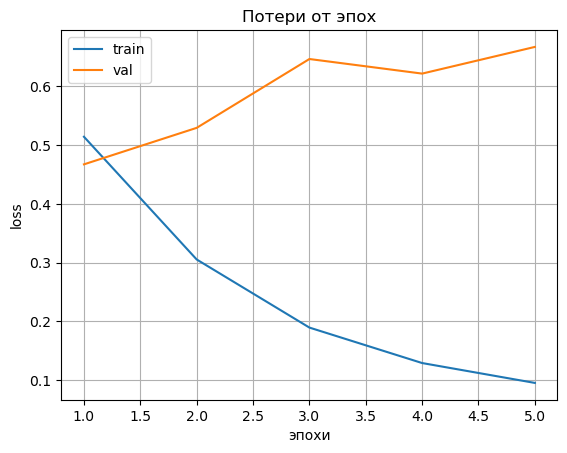

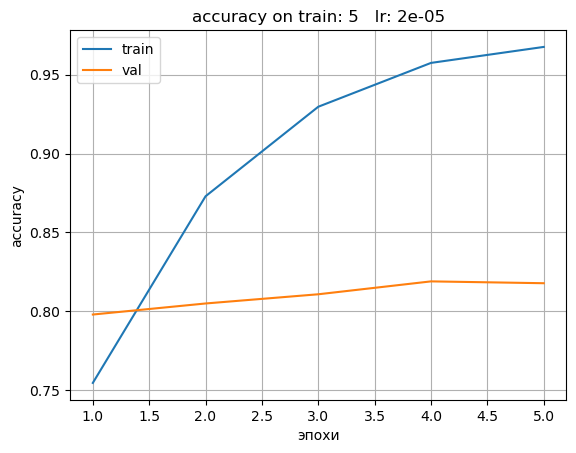

In [26]:
optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5,
                  eps = 1e-8
                  )
total_steps = len(train_dataloader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

model, loss_history, metric_history =\
training_loop(
    name_model_folder = 'model_2',
    epoches = 5,
    model = model,
    optimizer = optimizer,
    metric_str = 'accuracy',
    scheduler_append = False,
    scheduler = False,
    step_on = 'val_loss',
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = False,
    each__X__epoch = None,
    min_delta = None,
    patience = None,
    verbose_epoch = 1
)

# Тестирование

In [38]:
test_data = pd.read_csv('out_of_domain_dev.tsv', delimiter = '\t', header = None, names = ['sentence_source', 'label', 'label_notes', 'sentence'])
test_data.head()

,sentence_source,label,label_notes,sentence
0,clc95,1,NaN,somebody just left - guess who .
1,clc95,1,NaN,"they claimed they had settled on something , b..."
2,clc95,1,NaN,"if sam was going , sally would know where ."
3,clc95,1,NaN,"they 're going to serve the guests something ,..."
4,clc95,1,NaN,she 's reading . i ca n't imagine what .


In [39]:
sentences_test = test_data.sentence.values
test_labels = test_data.label.values
sentences_test = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences_test]
tokenized_test_text = [tokenizer.tokenize(sentence) for sentence in sentences_test]
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test_text]
input_ids_test = [torch.LongTensor(padding(x, 128)) for x in input_ids_test]

test_data = {
    'sequence': input_ids_test,
    'attention_mask': [attention_mask(i) for i in input_ids_test],
    'labels': test_data['label'].values,
}


test_inputs = torch.vstack(test_data['sequence'])
test_labels = torch.tensor(test_data['labels'])
test_attention_mask = torch.tensor(test_data['attention_mask'])

test_dataset = TensorDataset(test_inputs, test_attention_mask, test_labels)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32)


test_dataloader.dataset[0]

(tensor([ 101, 8307, 2074, 2187, 1011, 3984, 2040, 1012,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [40]:
test_metric_list = []
test_summarize_metric = 0.0
model.eval()

for features, attention_mask, labels in test_dataloader:
                
                features = features.to(device)
                labels = labels.to(device)
                attention_mask = attention_mask.to(device)

                outputs = model(features, token_type_ids = None, attention_mask = attention_mask, labels = labels)

                predict_labels = torch.argmax(outputs['logits'], axis = 1)
                test_summarize_metric += torch.sum(predict_labels == labels).item()
            
test_metric = test_summarize_metric / len(test_dataloader.dataset)
test_metric_list.append(test_metric)
np.mean(test_metric_list)

0.7945736434108527